# Introduction to gimVI

## Imputing missing genes in spatial data from sequencing data with gimVI

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scipy.stats import spearmanr
from scvi.data import cortex, smfish
from scvi.external import GIMVI

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
train_size = 0.8
spatial_data = smfish(save_path=save_dir.name)
seq_data = cortex(save_path=save_dir.name)

INFO     Downloading file at /tmp/tmpd6iw3zd4/osmFISH_SScortex_mouse_all_cell.loom                                 


Downloading...:   0%|          | 0/1121.0 [00:00<?, ?it/s]

Downloading...: 100%|██████████| 1121/1121.0 [00:00<00:00, 25922.31it/s]

INFO     Loading smFISH dataset                                                                                    


INFO     Downloading file at /tmp/tmpd6iw3zd4/expression.bin                                                       


Downloading...:   0%|          | 0/121129.0 [00:00<?, ?it/s]

Downloading...:   5%|▌         | 6489/121129.0 [00:00<00:01, 64855.58it/s]

Downloading...:  11%|█         | 12975/121129.0 [00:00<00:02, 46273.90it/s]

Downloading...:  15%|█▍        | 17913/121129.0 [00:00<00:04, 25226.60it/s]

Downloading...:  20%|██        | 24314/121129.0 [00:00<00:02, 33779.05it/s]

Downloading...:  24%|██▍       | 28858/121129.0 [00:00<00:02, 36383.37it/s]

Downloading...:  28%|██▊       | 34194/121129.0 [00:00<00:02, 40695.39it/s]

Downloading...:  35%|███▍      | 41944/121129.0 [00:01<00:01, 45119.01it/s]

Downloading...:  42%|████▏     | 50332/121129.0 [00:01<00:01, 39981.73it/s]

Downloading...:  48%|████▊     | 58721/121129.0 [00:01<00:01, 40224.01it/s]

Downloading...:  55%|█████▌    | 67109/121129.0 [00:01<00:01, 45429.82it/s]

Downloading...:  62%|██████▏   | 75498/121129.0 [00:01<00:00, 49262.20it/s]

Downloading...:  69%|██████▉   | 83887/121129.0 [00:01<00:00, 53278.35it/s]

Downloading...:  76%|███████▌  | 92275/121129.0 [00:02<00:00, 59860.30it/s]

Downloading...:  83%|████████▎ | 100664/121129.0 [00:02<00:00, 57977.03it/s]

Downloading...:  90%|█████████ | 109052/121129.0 [00:02<00:00, 63798.05it/s]

Downloading...:  97%|█████████▋| 117441/121129.0 [00:02<00:00, 47310.86it/s]

Downloading...: 121130it [00:02, 46828.32it/s]                              


INFO     Loading Cortex data from /tmp/tmpd6iw3zd4/expression.bin                                                  


INFO     Finished loading Cortex data                                                                              


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Preparing the data

In this section, we hold out some of the genes in the spatial dataset in order to test the imputation results

In [6]:
# only use genes in both datasets
seq_data = seq_data[:, spatial_data.var_names].copy()

seq_gene_names = seq_data.var_names
n_genes = seq_data.n_vars
n_train_genes = int(n_genes * train_size)

# randomly select training_genes
rand_train_gene_idx = np.random.choice(range(n_genes), n_train_genes, replace=False)
rand_test_gene_idx = sorted(set(range(n_genes)) - set(rand_train_gene_idx))
rand_train_genes = seq_gene_names[rand_train_gene_idx]
rand_test_genes = seq_gene_names[rand_test_gene_idx]

# spatial_data_partial has a subset of the genes to train on
spatial_data_partial = spatial_data[:, rand_train_genes].copy()

# remove cells with no counts
sc.pp.filter_cells(spatial_data_partial, min_counts=1)
sc.pp.filter_cells(seq_data, min_counts=1)

# setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(spatial_data_partial, labels_key="labels", batch_key="batch")
GIMVI.setup_anndata(seq_data, labels_key="labels")

# spatial_data should use the same cells as our training data
# cells may have been removed by scanpy.pp.filter_cells()
spatial_data = spatial_data[spatial_data_partial.obs_names]

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



## Creating the model and training

In [7]:
model = GIMVI(seq_data, spatial_data_partial)
model.train(max_epochs=200)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

Epoch 1/200:   0%|          | 1/200 [00:00<03:07,  1.06it/s, v_num=1]

Epoch 2/200:   0%|          | 1/200 [00:00<03:07,  1.06it/s, v_num=1]

Epoch 2/200:   1%|          | 2/200 [00:01<02:05,  1.58it/s, v_num=1]

Epoch 2/200:   1%|          | 2/200 [00:01<02:05,  1.58it/s, v_num=1]

Epoch 3/200:   1%|          | 2/200 [00:01<02:05,  1.58it/s, v_num=1]

Epoch 3/200:   2%|▏         | 3/200 [00:01<01:45,  1.87it/s, v_num=1]

Epoch 3/200:   2%|▏         | 3/200 [00:01<01:45,  1.87it/s, v_num=1]

Epoch 4/200:   2%|▏         | 3/200 [00:01<01:45,  1.87it/s, v_num=1]

Epoch 4/200:   2%|▏         | 4/200 [00:02<01:35,  2.05it/s, v_num=1]

Epoch 4/200:   2%|▏         | 4/200 [00:02<01:35,  2.05it/s, v_num=1]

Epoch 5/200:   2%|▏         | 4/200 [00:02<01:35,  2.05it/s, v_num=1]

Epoch 5/200:   2%|▎         | 5/200 [00:02<01:30,  2.16it/s, v_num=1]

Epoch 5/200:   2%|▎         | 5/200 [00:02<01:30,  2.16it/s, v_num=1]

Epoch 6/200:   2%|▎         | 5/200 [00:02<01:30,  2.16it/s, v_num=1]

Epoch 6/200:   3%|▎         | 6/200 [00:03<01:26,  2.24it/s, v_num=1]

Epoch 6/200:   3%|▎         | 6/200 [00:03<01:26,  2.24it/s, v_num=1]

Epoch 7/200:   3%|▎         | 6/200 [00:03<01:26,  2.24it/s, v_num=1]

Epoch 7/200:   4%|▎         | 7/200 [00:03<01:24,  2.29it/s, v_num=1]

Epoch 7/200:   4%|▎         | 7/200 [00:03<01:24,  2.29it/s, v_num=1]

Epoch 8/200:   4%|▎         | 7/200 [00:03<01:24,  2.29it/s, v_num=1]

Epoch 8/200:   4%|▍         | 8/200 [00:03<01:22,  2.33it/s, v_num=1]

Epoch 8/200:   4%|▍         | 8/200 [00:03<01:22,  2.33it/s, v_num=1]

Epoch 9/200:   4%|▍         | 8/200 [00:03<01:22,  2.33it/s, v_num=1]

Epoch 9/200:   4%|▍         | 9/200 [00:04<01:21,  2.35it/s, v_num=1]

Epoch 9/200:   4%|▍         | 9/200 [00:04<01:21,  2.35it/s, v_num=1]

Epoch 10/200:   4%|▍         | 9/200 [00:04<01:21,  2.35it/s, v_num=1]

Epoch 10/200:   5%|▌         | 10/200 [00:04<01:20,  2.37it/s, v_num=1]

Epoch 10/200:   5%|▌         | 10/200 [00:04<01:20,  2.37it/s, v_num=1]

Epoch 11/200:   5%|▌         | 10/200 [00:04<01:20,  2.37it/s, v_num=1]

Epoch 11/200:   6%|▌         | 11/200 [00:05<01:19,  2.38it/s, v_num=1]

Epoch 11/200:   6%|▌         | 11/200 [00:05<01:19,  2.38it/s, v_num=1]

Epoch 12/200:   6%|▌         | 11/200 [00:05<01:19,  2.38it/s, v_num=1]

Epoch 12/200:   6%|▌         | 12/200 [00:05<01:18,  2.39it/s, v_num=1]

Epoch 12/200:   6%|▌         | 12/200 [00:05<01:18,  2.39it/s, v_num=1]

Epoch 13/200:   6%|▌         | 12/200 [00:05<01:18,  2.39it/s, v_num=1]

Epoch 13/200:   6%|▋         | 13/200 [00:05<01:18,  2.39it/s, v_num=1]

Epoch 13/200:   6%|▋         | 13/200 [00:05<01:18,  2.39it/s, v_num=1]

Epoch 14/200:   6%|▋         | 13/200 [00:05<01:18,  2.39it/s, v_num=1]

Epoch 14/200:   7%|▋         | 14/200 [00:06<01:17,  2.40it/s, v_num=1]

Epoch 14/200:   7%|▋         | 14/200 [00:06<01:17,  2.40it/s, v_num=1]

Epoch 15/200:   7%|▋         | 14/200 [00:06<01:17,  2.40it/s, v_num=1]

Epoch 15/200:   8%|▊         | 15/200 [00:06<01:17,  2.40it/s, v_num=1]

Epoch 15/200:   8%|▊         | 15/200 [00:06<01:17,  2.40it/s, v_num=1]

Epoch 16/200:   8%|▊         | 15/200 [00:06<01:17,  2.40it/s, v_num=1]

Epoch 16/200:   8%|▊         | 16/200 [00:07<01:16,  2.40it/s, v_num=1]

Epoch 16/200:   8%|▊         | 16/200 [00:07<01:16,  2.40it/s, v_num=1]

Epoch 17/200:   8%|▊         | 16/200 [00:07<01:16,  2.40it/s, v_num=1]

Epoch 17/200:   8%|▊         | 17/200 [00:07<01:16,  2.40it/s, v_num=1]

Epoch 17/200:   8%|▊         | 17/200 [00:07<01:16,  2.40it/s, v_num=1]

Epoch 18/200:   8%|▊         | 17/200 [00:07<01:16,  2.40it/s, v_num=1]

Epoch 18/200:   9%|▉         | 18/200 [00:08<01:15,  2.40it/s, v_num=1]

Epoch 18/200:   9%|▉         | 18/200 [00:08<01:15,  2.40it/s, v_num=1]

Epoch 19/200:   9%|▉         | 18/200 [00:08<01:15,  2.40it/s, v_num=1]

Epoch 19/200:  10%|▉         | 19/200 [00:08<01:15,  2.40it/s, v_num=1]

Epoch 19/200:  10%|▉         | 19/200 [00:08<01:15,  2.40it/s, v_num=1]

Epoch 20/200:  10%|▉         | 19/200 [00:08<01:15,  2.40it/s, v_num=1]

Epoch 20/200:  10%|█         | 20/200 [00:08<01:14,  2.41it/s, v_num=1]

Epoch 20/200:  10%|█         | 20/200 [00:08<01:14,  2.41it/s, v_num=1]

Epoch 21/200:  10%|█         | 20/200 [00:08<01:14,  2.41it/s, v_num=1]

Epoch 21/200:  10%|█         | 21/200 [00:09<01:14,  2.41it/s, v_num=1]

Epoch 21/200:  10%|█         | 21/200 [00:09<01:14,  2.41it/s, v_num=1]

Epoch 22/200:  10%|█         | 21/200 [00:09<01:14,  2.41it/s, v_num=1]

Epoch 22/200:  11%|█         | 22/200 [00:09<01:13,  2.41it/s, v_num=1]

Epoch 22/200:  11%|█         | 22/200 [00:09<01:13,  2.41it/s, v_num=1]

Epoch 23/200:  11%|█         | 22/200 [00:09<01:13,  2.41it/s, v_num=1]

Epoch 23/200:  12%|█▏        | 23/200 [00:10<01:13,  2.41it/s, v_num=1]

Epoch 23/200:  12%|█▏        | 23/200 [00:10<01:13,  2.41it/s, v_num=1]

Epoch 24/200:  12%|█▏        | 23/200 [00:10<01:13,  2.41it/s, v_num=1]

Epoch 24/200:  12%|█▏        | 24/200 [00:10<01:13,  2.41it/s, v_num=1]

Epoch 24/200:  12%|█▏        | 24/200 [00:10<01:13,  2.41it/s, v_num=1]

Epoch 25/200:  12%|█▏        | 24/200 [00:10<01:13,  2.41it/s, v_num=1]

Epoch 25/200:  12%|█▎        | 25/200 [00:10<01:12,  2.41it/s, v_num=1]

Epoch 25/200:  12%|█▎        | 25/200 [00:10<01:12,  2.41it/s, v_num=1]

Epoch 26/200:  12%|█▎        | 25/200 [00:10<01:12,  2.41it/s, v_num=1]

Epoch 26/200:  13%|█▎        | 26/200 [00:11<01:12,  2.40it/s, v_num=1]

Epoch 26/200:  13%|█▎        | 26/200 [00:11<01:12,  2.40it/s, v_num=1]

Epoch 27/200:  13%|█▎        | 26/200 [00:11<01:12,  2.40it/s, v_num=1]

Epoch 27/200:  14%|█▎        | 27/200 [00:11<01:11,  2.41it/s, v_num=1]

Epoch 27/200:  14%|█▎        | 27/200 [00:11<01:11,  2.41it/s, v_num=1]

Epoch 28/200:  14%|█▎        | 27/200 [00:11<01:11,  2.41it/s, v_num=1]

Epoch 28/200:  14%|█▍        | 28/200 [00:12<01:11,  2.40it/s, v_num=1]

Epoch 28/200:  14%|█▍        | 28/200 [00:12<01:11,  2.40it/s, v_num=1]

Epoch 29/200:  14%|█▍        | 28/200 [00:12<01:11,  2.40it/s, v_num=1]

Epoch 29/200:  14%|█▍        | 29/200 [00:12<01:11,  2.40it/s, v_num=1]

Epoch 29/200:  14%|█▍        | 29/200 [00:12<01:11,  2.40it/s, v_num=1]

Epoch 30/200:  14%|█▍        | 29/200 [00:12<01:11,  2.40it/s, v_num=1]

Epoch 30/200:  15%|█▌        | 30/200 [00:12<01:10,  2.41it/s, v_num=1]

Epoch 30/200:  15%|█▌        | 30/200 [00:13<01:10,  2.41it/s, v_num=1]

Epoch 31/200:  15%|█▌        | 30/200 [00:13<01:10,  2.41it/s, v_num=1]

Epoch 31/200:  16%|█▌        | 31/200 [00:13<01:10,  2.41it/s, v_num=1]

Epoch 31/200:  16%|█▌        | 31/200 [00:13<01:10,  2.41it/s, v_num=1]

Epoch 32/200:  16%|█▌        | 31/200 [00:13<01:10,  2.41it/s, v_num=1]

Epoch 32/200:  16%|█▌        | 32/200 [00:13<01:09,  2.41it/s, v_num=1]

Epoch 32/200:  16%|█▌        | 32/200 [00:13<01:09,  2.41it/s, v_num=1]

Epoch 33/200:  16%|█▌        | 32/200 [00:13<01:09,  2.41it/s, v_num=1]

Epoch 33/200:  16%|█▋        | 33/200 [00:14<01:09,  2.41it/s, v_num=1]

Epoch 33/200:  16%|█▋        | 33/200 [00:14<01:09,  2.41it/s, v_num=1]

Epoch 34/200:  16%|█▋        | 33/200 [00:14<01:09,  2.41it/s, v_num=1]

Epoch 34/200:  17%|█▋        | 34/200 [00:14<01:09,  2.40it/s, v_num=1]

Epoch 34/200:  17%|█▋        | 34/200 [00:14<01:09,  2.40it/s, v_num=1]

Epoch 35/200:  17%|█▋        | 34/200 [00:14<01:09,  2.40it/s, v_num=1]

Epoch 35/200:  18%|█▊        | 35/200 [00:15<01:08,  2.40it/s, v_num=1]

Epoch 35/200:  18%|█▊        | 35/200 [00:15<01:08,  2.40it/s, v_num=1]

Epoch 36/200:  18%|█▊        | 35/200 [00:15<01:08,  2.40it/s, v_num=1]

Epoch 36/200:  18%|█▊        | 36/200 [00:15<01:08,  2.40it/s, v_num=1]

Epoch 36/200:  18%|█▊        | 36/200 [00:15<01:08,  2.40it/s, v_num=1]

Epoch 37/200:  18%|█▊        | 36/200 [00:15<01:08,  2.40it/s, v_num=1]

Epoch 37/200:  18%|█▊        | 37/200 [00:15<01:07,  2.40it/s, v_num=1]

Epoch 37/200:  18%|█▊        | 37/200 [00:15<01:07,  2.40it/s, v_num=1]

Epoch 38/200:  18%|█▊        | 37/200 [00:15<01:07,  2.40it/s, v_num=1]

Epoch 38/200:  19%|█▉        | 38/200 [00:16<01:07,  2.40it/s, v_num=1]

Epoch 38/200:  19%|█▉        | 38/200 [00:16<01:07,  2.40it/s, v_num=1]

Epoch 39/200:  19%|█▉        | 38/200 [00:16<01:07,  2.40it/s, v_num=1]

Epoch 39/200:  20%|█▉        | 39/200 [00:16<01:06,  2.40it/s, v_num=1]

Epoch 39/200:  20%|█▉        | 39/200 [00:16<01:06,  2.40it/s, v_num=1]

Epoch 40/200:  20%|█▉        | 39/200 [00:16<01:06,  2.40it/s, v_num=1]

Epoch 40/200:  20%|██        | 40/200 [00:17<01:06,  2.40it/s, v_num=1]

Epoch 40/200:  20%|██        | 40/200 [00:17<01:06,  2.40it/s, v_num=1]

Epoch 41/200:  20%|██        | 40/200 [00:17<01:06,  2.40it/s, v_num=1]

Epoch 41/200:  20%|██        | 41/200 [00:17<01:06,  2.40it/s, v_num=1]

Epoch 41/200:  20%|██        | 41/200 [00:17<01:06,  2.40it/s, v_num=1]

Epoch 42/200:  20%|██        | 41/200 [00:17<01:06,  2.40it/s, v_num=1]

Epoch 42/200:  21%|██        | 42/200 [00:17<01:05,  2.41it/s, v_num=1]

Epoch 42/200:  21%|██        | 42/200 [00:17<01:05,  2.41it/s, v_num=1]

Epoch 43/200:  21%|██        | 42/200 [00:17<01:05,  2.41it/s, v_num=1]

Epoch 43/200:  22%|██▏       | 43/200 [00:18<01:05,  2.41it/s, v_num=1]

Epoch 43/200:  22%|██▏       | 43/200 [00:18<01:05,  2.41it/s, v_num=1]

Epoch 44/200:  22%|██▏       | 43/200 [00:18<01:05,  2.41it/s, v_num=1]

Epoch 44/200:  22%|██▏       | 44/200 [00:18<01:04,  2.41it/s, v_num=1]

Epoch 44/200:  22%|██▏       | 44/200 [00:18<01:04,  2.41it/s, v_num=1]

Epoch 45/200:  22%|██▏       | 44/200 [00:18<01:04,  2.41it/s, v_num=1]

Epoch 45/200:  22%|██▎       | 45/200 [00:19<01:04,  2.41it/s, v_num=1]

Epoch 45/200:  22%|██▎       | 45/200 [00:19<01:04,  2.41it/s, v_num=1]

Epoch 46/200:  22%|██▎       | 45/200 [00:19<01:04,  2.41it/s, v_num=1]

Epoch 46/200:  23%|██▎       | 46/200 [00:19<01:03,  2.41it/s, v_num=1]

Epoch 46/200:  23%|██▎       | 46/200 [00:19<01:03,  2.41it/s, v_num=1]

Epoch 47/200:  23%|██▎       | 46/200 [00:19<01:03,  2.41it/s, v_num=1]

Epoch 47/200:  24%|██▎       | 47/200 [00:20<01:03,  2.41it/s, v_num=1]

Epoch 47/200:  24%|██▎       | 47/200 [00:20<01:03,  2.41it/s, v_num=1]

Epoch 48/200:  24%|██▎       | 47/200 [00:20<01:03,  2.41it/s, v_num=1]

Epoch 48/200:  24%|██▍       | 48/200 [00:20<01:03,  2.41it/s, v_num=1]

Epoch 48/200:  24%|██▍       | 48/200 [00:20<01:03,  2.41it/s, v_num=1]

Epoch 49/200:  24%|██▍       | 48/200 [00:20<01:03,  2.41it/s, v_num=1]

Epoch 49/200:  24%|██▍       | 49/200 [00:20<01:02,  2.41it/s, v_num=1]

Epoch 49/200:  24%|██▍       | 49/200 [00:20<01:02,  2.41it/s, v_num=1]

Epoch 50/200:  24%|██▍       | 49/200 [00:20<01:02,  2.41it/s, v_num=1]

Epoch 50/200:  25%|██▌       | 50/200 [00:21<01:02,  2.41it/s, v_num=1]

Epoch 50/200:  25%|██▌       | 50/200 [00:21<01:02,  2.41it/s, v_num=1]

Epoch 51/200:  25%|██▌       | 50/200 [00:21<01:02,  2.41it/s, v_num=1]

Epoch 51/200:  26%|██▌       | 51/200 [00:21<01:02,  2.40it/s, v_num=1]

Epoch 51/200:  26%|██▌       | 51/200 [00:21<01:02,  2.40it/s, v_num=1]

Epoch 52/200:  26%|██▌       | 51/200 [00:21<01:02,  2.40it/s, v_num=1]

Epoch 52/200:  26%|██▌       | 52/200 [00:22<01:01,  2.40it/s, v_num=1]

Epoch 52/200:  26%|██▌       | 52/200 [00:22<01:01,  2.40it/s, v_num=1]

Epoch 53/200:  26%|██▌       | 52/200 [00:22<01:01,  2.40it/s, v_num=1]

Epoch 53/200:  26%|██▋       | 53/200 [00:22<01:01,  2.40it/s, v_num=1]

Epoch 53/200:  26%|██▋       | 53/200 [00:22<01:01,  2.40it/s, v_num=1]

Epoch 54/200:  26%|██▋       | 53/200 [00:22<01:01,  2.40it/s, v_num=1]

Epoch 54/200:  27%|██▋       | 54/200 [00:22<01:00,  2.40it/s, v_num=1]

Epoch 54/200:  27%|██▋       | 54/200 [00:22<01:00,  2.40it/s, v_num=1]

Epoch 55/200:  27%|██▋       | 54/200 [00:22<01:00,  2.40it/s, v_num=1]

Epoch 55/200:  28%|██▊       | 55/200 [00:23<01:00,  2.40it/s, v_num=1]

Epoch 55/200:  28%|██▊       | 55/200 [00:23<01:00,  2.40it/s, v_num=1]

Epoch 56/200:  28%|██▊       | 55/200 [00:23<01:00,  2.40it/s, v_num=1]

Epoch 56/200:  28%|██▊       | 56/200 [00:23<00:59,  2.41it/s, v_num=1]

Epoch 56/200:  28%|██▊       | 56/200 [00:23<00:59,  2.41it/s, v_num=1]

Epoch 57/200:  28%|██▊       | 56/200 [00:23<00:59,  2.41it/s, v_num=1]

Epoch 57/200:  28%|██▊       | 57/200 [00:24<00:59,  2.40it/s, v_num=1]

Epoch 57/200:  28%|██▊       | 57/200 [00:24<00:59,  2.40it/s, v_num=1]

Epoch 58/200:  28%|██▊       | 57/200 [00:24<00:59,  2.40it/s, v_num=1]

Epoch 58/200:  29%|██▉       | 58/200 [00:24<00:59,  2.40it/s, v_num=1]

Epoch 58/200:  29%|██▉       | 58/200 [00:24<00:59,  2.40it/s, v_num=1]

Epoch 59/200:  29%|██▉       | 58/200 [00:24<00:59,  2.40it/s, v_num=1]

Epoch 59/200:  30%|██▉       | 59/200 [00:25<00:58,  2.40it/s, v_num=1]

Epoch 59/200:  30%|██▉       | 59/200 [00:25<00:58,  2.40it/s, v_num=1]

Epoch 60/200:  30%|██▉       | 59/200 [00:25<00:58,  2.40it/s, v_num=1]

Epoch 60/200:  30%|███       | 60/200 [00:25<00:58,  2.40it/s, v_num=1]

Epoch 60/200:  30%|███       | 60/200 [00:25<00:58,  2.40it/s, v_num=1]

Epoch 61/200:  30%|███       | 60/200 [00:25<00:58,  2.40it/s, v_num=1]

Epoch 61/200:  30%|███       | 61/200 [00:25<00:57,  2.40it/s, v_num=1]

Epoch 61/200:  30%|███       | 61/200 [00:25<00:57,  2.40it/s, v_num=1]

Epoch 62/200:  30%|███       | 61/200 [00:25<00:57,  2.40it/s, v_num=1]

Epoch 62/200:  31%|███       | 62/200 [00:26<00:57,  2.40it/s, v_num=1]

Epoch 62/200:  31%|███       | 62/200 [00:26<00:57,  2.40it/s, v_num=1]

Epoch 63/200:  31%|███       | 62/200 [00:26<00:57,  2.40it/s, v_num=1]

Epoch 63/200:  32%|███▏      | 63/200 [00:26<00:56,  2.40it/s, v_num=1]

Epoch 63/200:  32%|███▏      | 63/200 [00:26<00:56,  2.40it/s, v_num=1]

Epoch 64/200:  32%|███▏      | 63/200 [00:26<00:56,  2.40it/s, v_num=1]

Epoch 64/200:  32%|███▏      | 64/200 [00:27<00:56,  2.40it/s, v_num=1]

Epoch 64/200:  32%|███▏      | 64/200 [00:27<00:56,  2.40it/s, v_num=1]

Epoch 65/200:  32%|███▏      | 64/200 [00:27<00:56,  2.40it/s, v_num=1]

Epoch 65/200:  32%|███▎      | 65/200 [00:27<00:56,  2.40it/s, v_num=1]

Epoch 65/200:  32%|███▎      | 65/200 [00:27<00:56,  2.40it/s, v_num=1]

Epoch 66/200:  32%|███▎      | 65/200 [00:27<00:56,  2.40it/s, v_num=1]

Epoch 66/200:  33%|███▎      | 66/200 [00:27<00:55,  2.40it/s, v_num=1]

Epoch 66/200:  33%|███▎      | 66/200 [00:27<00:55,  2.40it/s, v_num=1]

Epoch 67/200:  33%|███▎      | 66/200 [00:27<00:55,  2.40it/s, v_num=1]

Epoch 67/200:  34%|███▎      | 67/200 [00:28<00:55,  2.40it/s, v_num=1]

Epoch 67/200:  34%|███▎      | 67/200 [00:28<00:55,  2.40it/s, v_num=1]

Epoch 68/200:  34%|███▎      | 67/200 [00:28<00:55,  2.40it/s, v_num=1]

Epoch 68/200:  34%|███▍      | 68/200 [00:28<00:54,  2.40it/s, v_num=1]

Epoch 68/200:  34%|███▍      | 68/200 [00:28<00:54,  2.40it/s, v_num=1]

Epoch 69/200:  34%|███▍      | 68/200 [00:28<00:54,  2.40it/s, v_num=1]

Epoch 69/200:  34%|███▍      | 69/200 [00:29<00:54,  2.40it/s, v_num=1]

Epoch 69/200:  34%|███▍      | 69/200 [00:29<00:54,  2.40it/s, v_num=1]

Epoch 70/200:  34%|███▍      | 69/200 [00:29<00:54,  2.40it/s, v_num=1]

Epoch 70/200:  35%|███▌      | 70/200 [00:29<00:54,  2.40it/s, v_num=1]

Epoch 70/200:  35%|███▌      | 70/200 [00:29<00:54,  2.40it/s, v_num=1]

Epoch 71/200:  35%|███▌      | 70/200 [00:29<00:54,  2.40it/s, v_num=1]

Epoch 71/200:  36%|███▌      | 71/200 [00:30<00:53,  2.40it/s, v_num=1]

Epoch 71/200:  36%|███▌      | 71/200 [00:30<00:53,  2.40it/s, v_num=1]

Epoch 72/200:  36%|███▌      | 71/200 [00:30<00:53,  2.40it/s, v_num=1]

Epoch 72/200:  36%|███▌      | 72/200 [00:30<00:53,  2.41it/s, v_num=1]

Epoch 72/200:  36%|███▌      | 72/200 [00:30<00:53,  2.41it/s, v_num=1]

Epoch 73/200:  36%|███▌      | 72/200 [00:30<00:53,  2.41it/s, v_num=1]

Epoch 73/200:  36%|███▋      | 73/200 [00:30<00:52,  2.41it/s, v_num=1]

Epoch 73/200:  36%|███▋      | 73/200 [00:30<00:52,  2.41it/s, v_num=1]

Epoch 74/200:  36%|███▋      | 73/200 [00:30<00:52,  2.41it/s, v_num=1]

Epoch 74/200:  37%|███▋      | 74/200 [00:31<00:52,  2.41it/s, v_num=1]

Epoch 74/200:  37%|███▋      | 74/200 [00:31<00:52,  2.41it/s, v_num=1]

Epoch 75/200:  37%|███▋      | 74/200 [00:31<00:52,  2.41it/s, v_num=1]

Epoch 75/200:  38%|███▊      | 75/200 [00:31<00:51,  2.41it/s, v_num=1]

Epoch 75/200:  38%|███▊      | 75/200 [00:31<00:51,  2.41it/s, v_num=1]

Epoch 76/200:  38%|███▊      | 75/200 [00:31<00:51,  2.41it/s, v_num=1]

Epoch 76/200:  38%|███▊      | 76/200 [00:32<00:51,  2.41it/s, v_num=1]

Epoch 76/200:  38%|███▊      | 76/200 [00:32<00:51,  2.41it/s, v_num=1]

Epoch 77/200:  38%|███▊      | 76/200 [00:32<00:51,  2.41it/s, v_num=1]

Epoch 77/200:  38%|███▊      | 77/200 [00:32<00:51,  2.40it/s, v_num=1]

Epoch 77/200:  38%|███▊      | 77/200 [00:32<00:51,  2.40it/s, v_num=1]

Epoch 78/200:  38%|███▊      | 77/200 [00:32<00:51,  2.40it/s, v_num=1]

Epoch 78/200:  39%|███▉      | 78/200 [00:32<00:50,  2.41it/s, v_num=1]

Epoch 78/200:  39%|███▉      | 78/200 [00:32<00:50,  2.41it/s, v_num=1]

Epoch 79/200:  39%|███▉      | 78/200 [00:32<00:50,  2.41it/s, v_num=1]

Epoch 79/200:  40%|███▉      | 79/200 [00:33<00:50,  2.41it/s, v_num=1]

Epoch 79/200:  40%|███▉      | 79/200 [00:33<00:50,  2.41it/s, v_num=1]

Epoch 80/200:  40%|███▉      | 79/200 [00:33<00:50,  2.41it/s, v_num=1]

Epoch 80/200:  40%|████      | 80/200 [00:33<00:49,  2.40it/s, v_num=1]

Epoch 80/200:  40%|████      | 80/200 [00:33<00:49,  2.40it/s, v_num=1]

Epoch 81/200:  40%|████      | 80/200 [00:33<00:49,  2.40it/s, v_num=1]

Epoch 81/200:  40%|████      | 81/200 [00:34<00:49,  2.40it/s, v_num=1]

Epoch 81/200:  40%|████      | 81/200 [00:34<00:49,  2.40it/s, v_num=1]

Epoch 82/200:  40%|████      | 81/200 [00:34<00:49,  2.40it/s, v_num=1]

Epoch 82/200:  41%|████      | 82/200 [00:34<00:49,  2.40it/s, v_num=1]

Epoch 82/200:  41%|████      | 82/200 [00:34<00:49,  2.40it/s, v_num=1]

Epoch 83/200:  41%|████      | 82/200 [00:34<00:49,  2.40it/s, v_num=1]

Epoch 83/200:  42%|████▏     | 83/200 [00:35<00:48,  2.40it/s, v_num=1]

Epoch 83/200:  42%|████▏     | 83/200 [00:35<00:48,  2.40it/s, v_num=1]

Epoch 84/200:  42%|████▏     | 83/200 [00:35<00:48,  2.40it/s, v_num=1]

Epoch 84/200:  42%|████▏     | 84/200 [00:35<00:48,  2.40it/s, v_num=1]

Epoch 84/200:  42%|████▏     | 84/200 [00:35<00:48,  2.40it/s, v_num=1]

Epoch 85/200:  42%|████▏     | 84/200 [00:35<00:48,  2.40it/s, v_num=1]

Epoch 85/200:  42%|████▎     | 85/200 [00:35<00:47,  2.40it/s, v_num=1]

Epoch 85/200:  42%|████▎     | 85/200 [00:35<00:47,  2.40it/s, v_num=1]

Epoch 86/200:  42%|████▎     | 85/200 [00:35<00:47,  2.40it/s, v_num=1]

Epoch 86/200:  43%|████▎     | 86/200 [00:36<00:47,  2.40it/s, v_num=1]

Epoch 86/200:  43%|████▎     | 86/200 [00:36<00:47,  2.40it/s, v_num=1]

Epoch 87/200:  43%|████▎     | 86/200 [00:36<00:47,  2.40it/s, v_num=1]

Epoch 87/200:  44%|████▎     | 87/200 [00:36<00:47,  2.40it/s, v_num=1]

Epoch 87/200:  44%|████▎     | 87/200 [00:36<00:47,  2.40it/s, v_num=1]

Epoch 88/200:  44%|████▎     | 87/200 [00:36<00:47,  2.40it/s, v_num=1]

Epoch 88/200:  44%|████▍     | 88/200 [00:37<00:46,  2.41it/s, v_num=1]

Epoch 88/200:  44%|████▍     | 88/200 [00:37<00:46,  2.41it/s, v_num=1]

Epoch 89/200:  44%|████▍     | 88/200 [00:37<00:46,  2.41it/s, v_num=1]

Epoch 89/200:  44%|████▍     | 89/200 [00:37<00:46,  2.41it/s, v_num=1]

Epoch 89/200:  44%|████▍     | 89/200 [00:37<00:46,  2.41it/s, v_num=1]

Epoch 90/200:  44%|████▍     | 89/200 [00:37<00:46,  2.41it/s, v_num=1]

Epoch 90/200:  45%|████▌     | 90/200 [00:37<00:45,  2.40it/s, v_num=1]

Epoch 90/200:  45%|████▌     | 90/200 [00:37<00:45,  2.40it/s, v_num=1]

Epoch 91/200:  45%|████▌     | 90/200 [00:37<00:45,  2.40it/s, v_num=1]

Epoch 91/200:  46%|████▌     | 91/200 [00:38<00:45,  2.40it/s, v_num=1]

Epoch 91/200:  46%|████▌     | 91/200 [00:38<00:45,  2.40it/s, v_num=1]

Epoch 92/200:  46%|████▌     | 91/200 [00:38<00:45,  2.40it/s, v_num=1]

Epoch 92/200:  46%|████▌     | 92/200 [00:38<00:45,  2.39it/s, v_num=1]

Epoch 92/200:  46%|████▌     | 92/200 [00:38<00:45,  2.39it/s, v_num=1]

Epoch 93/200:  46%|████▌     | 92/200 [00:38<00:45,  2.39it/s, v_num=1]

Epoch 93/200:  46%|████▋     | 93/200 [00:39<00:44,  2.39it/s, v_num=1]

Epoch 93/200:  46%|████▋     | 93/200 [00:39<00:44,  2.39it/s, v_num=1]

Epoch 94/200:  46%|████▋     | 93/200 [00:39<00:44,  2.39it/s, v_num=1]

Epoch 94/200:  47%|████▋     | 94/200 [00:39<00:44,  2.40it/s, v_num=1]

Epoch 94/200:  47%|████▋     | 94/200 [00:39<00:44,  2.40it/s, v_num=1]

Epoch 95/200:  47%|████▋     | 94/200 [00:39<00:44,  2.40it/s, v_num=1]

Epoch 95/200:  48%|████▊     | 95/200 [00:40<00:43,  2.40it/s, v_num=1]

Epoch 95/200:  48%|████▊     | 95/200 [00:40<00:43,  2.40it/s, v_num=1]

Epoch 96/200:  48%|████▊     | 95/200 [00:40<00:43,  2.40it/s, v_num=1]

Epoch 96/200:  48%|████▊     | 96/200 [00:40<00:43,  2.40it/s, v_num=1]

Epoch 96/200:  48%|████▊     | 96/200 [00:40<00:43,  2.40it/s, v_num=1]

Epoch 97/200:  48%|████▊     | 96/200 [00:40<00:43,  2.40it/s, v_num=1]

Epoch 97/200:  48%|████▊     | 97/200 [00:40<00:42,  2.40it/s, v_num=1]

Epoch 97/200:  48%|████▊     | 97/200 [00:40<00:42,  2.40it/s, v_num=1]

Epoch 98/200:  48%|████▊     | 97/200 [00:40<00:42,  2.40it/s, v_num=1]

Epoch 98/200:  49%|████▉     | 98/200 [00:41<00:42,  2.40it/s, v_num=1]

Epoch 98/200:  49%|████▉     | 98/200 [00:41<00:42,  2.40it/s, v_num=1]

Epoch 99/200:  49%|████▉     | 98/200 [00:41<00:42,  2.40it/s, v_num=1]

Epoch 99/200:  50%|████▉     | 99/200 [00:41<00:41,  2.41it/s, v_num=1]

Epoch 99/200:  50%|████▉     | 99/200 [00:41<00:41,  2.41it/s, v_num=1]

Epoch 100/200:  50%|████▉     | 99/200 [00:41<00:41,  2.41it/s, v_num=1]

Epoch 100/200:  50%|█████     | 100/200 [00:42<00:41,  2.40it/s, v_num=1]

Epoch 100/200:  50%|█████     | 100/200 [00:42<00:41,  2.40it/s, v_num=1]

Epoch 101/200:  50%|█████     | 100/200 [00:42<00:41,  2.40it/s, v_num=1]

Epoch 101/200:  50%|█████     | 101/200 [00:42<00:41,  2.40it/s, v_num=1]

Epoch 101/200:  50%|█████     | 101/200 [00:42<00:41,  2.40it/s, v_num=1]

Epoch 102/200:  50%|█████     | 101/200 [00:42<00:41,  2.40it/s, v_num=1]

Epoch 102/200:  51%|█████     | 102/200 [00:42<00:40,  2.40it/s, v_num=1]

Epoch 102/200:  51%|█████     | 102/200 [00:42<00:40,  2.40it/s, v_num=1]

Epoch 103/200:  51%|█████     | 102/200 [00:42<00:40,  2.40it/s, v_num=1]

Epoch 103/200:  52%|█████▏    | 103/200 [00:43<00:40,  2.40it/s, v_num=1]

Epoch 103/200:  52%|█████▏    | 103/200 [00:43<00:40,  2.40it/s, v_num=1]

Epoch 104/200:  52%|█████▏    | 103/200 [00:43<00:40,  2.40it/s, v_num=1]

Epoch 104/200:  52%|█████▏    | 104/200 [00:43<00:39,  2.40it/s, v_num=1]

Epoch 104/200:  52%|█████▏    | 104/200 [00:43<00:39,  2.40it/s, v_num=1]

Epoch 105/200:  52%|█████▏    | 104/200 [00:43<00:39,  2.40it/s, v_num=1]

Epoch 105/200:  52%|█████▎    | 105/200 [00:44<00:39,  2.40it/s, v_num=1]

Epoch 105/200:  52%|█████▎    | 105/200 [00:44<00:39,  2.40it/s, v_num=1]

Epoch 106/200:  52%|█████▎    | 105/200 [00:44<00:39,  2.40it/s, v_num=1]

Epoch 106/200:  53%|█████▎    | 106/200 [00:44<00:39,  2.40it/s, v_num=1]

Epoch 106/200:  53%|█████▎    | 106/200 [00:44<00:39,  2.40it/s, v_num=1]

Epoch 107/200:  53%|█████▎    | 106/200 [00:44<00:39,  2.40it/s, v_num=1]

Epoch 107/200:  54%|█████▎    | 107/200 [00:45<00:38,  2.40it/s, v_num=1]

Epoch 107/200:  54%|█████▎    | 107/200 [00:45<00:38,  2.40it/s, v_num=1]

Epoch 108/200:  54%|█████▎    | 107/200 [00:45<00:38,  2.40it/s, v_num=1]

Epoch 108/200:  54%|█████▍    | 108/200 [00:45<00:38,  2.40it/s, v_num=1]

Epoch 108/200:  54%|█████▍    | 108/200 [00:45<00:38,  2.40it/s, v_num=1]

Epoch 109/200:  54%|█████▍    | 108/200 [00:45<00:38,  2.40it/s, v_num=1]

Epoch 109/200:  55%|█████▍    | 109/200 [00:45<00:37,  2.40it/s, v_num=1]

Epoch 109/200:  55%|█████▍    | 109/200 [00:45<00:37,  2.40it/s, v_num=1]

Epoch 110/200:  55%|█████▍    | 109/200 [00:45<00:37,  2.40it/s, v_num=1]

Epoch 110/200:  55%|█████▌    | 110/200 [00:46<00:37,  2.40it/s, v_num=1]

Epoch 110/200:  55%|█████▌    | 110/200 [00:46<00:37,  2.40it/s, v_num=1]

Epoch 111/200:  55%|█████▌    | 110/200 [00:46<00:37,  2.40it/s, v_num=1]

Epoch 111/200:  56%|█████▌    | 111/200 [00:46<00:37,  2.40it/s, v_num=1]

Epoch 111/200:  56%|█████▌    | 111/200 [00:46<00:37,  2.40it/s, v_num=1]

Epoch 112/200:  56%|█████▌    | 111/200 [00:46<00:37,  2.40it/s, v_num=1]

Epoch 112/200:  56%|█████▌    | 112/200 [00:47<00:36,  2.42it/s, v_num=1]

Epoch 112/200:  56%|█████▌    | 112/200 [00:47<00:36,  2.42it/s, v_num=1]

Epoch 113/200:  56%|█████▌    | 112/200 [00:47<00:36,  2.42it/s, v_num=1]

Epoch 113/200:  56%|█████▋    | 113/200 [00:47<00:36,  2.41it/s, v_num=1]

Epoch 113/200:  56%|█████▋    | 113/200 [00:47<00:36,  2.41it/s, v_num=1]

Epoch 114/200:  56%|█████▋    | 113/200 [00:47<00:36,  2.41it/s, v_num=1]

Epoch 114/200:  57%|█████▋    | 114/200 [00:47<00:35,  2.41it/s, v_num=1]

Epoch 114/200:  57%|█████▋    | 114/200 [00:47<00:35,  2.41it/s, v_num=1]

Epoch 115/200:  57%|█████▋    | 114/200 [00:47<00:35,  2.41it/s, v_num=1]

Epoch 115/200:  57%|█████▊    | 115/200 [00:48<00:35,  2.40it/s, v_num=1]

Epoch 115/200:  57%|█████▊    | 115/200 [00:48<00:35,  2.40it/s, v_num=1]

Epoch 116/200:  57%|█████▊    | 115/200 [00:48<00:35,  2.40it/s, v_num=1]

Epoch 116/200:  58%|█████▊    | 116/200 [00:48<00:34,  2.40it/s, v_num=1]

Epoch 116/200:  58%|█████▊    | 116/200 [00:48<00:34,  2.40it/s, v_num=1]

Epoch 117/200:  58%|█████▊    | 116/200 [00:48<00:34,  2.40it/s, v_num=1]

Epoch 117/200:  58%|█████▊    | 117/200 [00:49<00:34,  2.41it/s, v_num=1]

Epoch 117/200:  58%|█████▊    | 117/200 [00:49<00:34,  2.41it/s, v_num=1]

Epoch 118/200:  58%|█████▊    | 117/200 [00:49<00:34,  2.41it/s, v_num=1]

Epoch 118/200:  59%|█████▉    | 118/200 [00:49<00:34,  2.41it/s, v_num=1]

Epoch 118/200:  59%|█████▉    | 118/200 [00:49<00:34,  2.41it/s, v_num=1]

Epoch 119/200:  59%|█████▉    | 118/200 [00:49<00:34,  2.41it/s, v_num=1]

Epoch 119/200:  60%|█████▉    | 119/200 [00:50<00:33,  2.41it/s, v_num=1]

Epoch 119/200:  60%|█████▉    | 119/200 [00:50<00:33,  2.41it/s, v_num=1]

Epoch 120/200:  60%|█████▉    | 119/200 [00:50<00:33,  2.41it/s, v_num=1]

Epoch 120/200:  60%|██████    | 120/200 [00:50<00:33,  2.41it/s, v_num=1]

Epoch 120/200:  60%|██████    | 120/200 [00:50<00:33,  2.41it/s, v_num=1]

Epoch 121/200:  60%|██████    | 120/200 [00:50<00:33,  2.41it/s, v_num=1]

Epoch 121/200:  60%|██████    | 121/200 [00:50<00:32,  2.41it/s, v_num=1]

Epoch 121/200:  60%|██████    | 121/200 [00:50<00:32,  2.41it/s, v_num=1]

Epoch 122/200:  60%|██████    | 121/200 [00:50<00:32,  2.41it/s, v_num=1]

Epoch 122/200:  61%|██████    | 122/200 [00:51<00:32,  2.41it/s, v_num=1]

Epoch 122/200:  61%|██████    | 122/200 [00:51<00:32,  2.41it/s, v_num=1]

Epoch 123/200:  61%|██████    | 122/200 [00:51<00:32,  2.41it/s, v_num=1]

Epoch 123/200:  62%|██████▏   | 123/200 [00:51<00:31,  2.41it/s, v_num=1]

Epoch 123/200:  62%|██████▏   | 123/200 [00:51<00:31,  2.41it/s, v_num=1]

Epoch 124/200:  62%|██████▏   | 123/200 [00:51<00:31,  2.41it/s, v_num=1]

Epoch 124/200:  62%|██████▏   | 124/200 [00:52<00:31,  2.41it/s, v_num=1]

Epoch 124/200:  62%|██████▏   | 124/200 [00:52<00:31,  2.41it/s, v_num=1]

Epoch 125/200:  62%|██████▏   | 124/200 [00:52<00:31,  2.41it/s, v_num=1]

Epoch 125/200:  62%|██████▎   | 125/200 [00:52<00:31,  2.40it/s, v_num=1]

Epoch 125/200:  62%|██████▎   | 125/200 [00:52<00:31,  2.40it/s, v_num=1]

Epoch 126/200:  62%|██████▎   | 125/200 [00:52<00:31,  2.40it/s, v_num=1]

Epoch 126/200:  63%|██████▎   | 126/200 [00:52<00:30,  2.40it/s, v_num=1]

Epoch 126/200:  63%|██████▎   | 126/200 [00:52<00:30,  2.40it/s, v_num=1]

Epoch 127/200:  63%|██████▎   | 126/200 [00:52<00:30,  2.40it/s, v_num=1]

Epoch 127/200:  64%|██████▎   | 127/200 [00:53<00:30,  2.40it/s, v_num=1]

Epoch 127/200:  64%|██████▎   | 127/200 [00:53<00:30,  2.40it/s, v_num=1]

Epoch 128/200:  64%|██████▎   | 127/200 [00:53<00:30,  2.40it/s, v_num=1]

Epoch 128/200:  64%|██████▍   | 128/200 [00:53<00:30,  2.40it/s, v_num=1]

Epoch 128/200:  64%|██████▍   | 128/200 [00:53<00:30,  2.40it/s, v_num=1]

Epoch 129/200:  64%|██████▍   | 128/200 [00:53<00:30,  2.40it/s, v_num=1]

Epoch 129/200:  64%|██████▍   | 129/200 [00:54<00:29,  2.40it/s, v_num=1]

Epoch 129/200:  64%|██████▍   | 129/200 [00:54<00:29,  2.40it/s, v_num=1]

Epoch 130/200:  64%|██████▍   | 129/200 [00:54<00:29,  2.40it/s, v_num=1]

Epoch 130/200:  65%|██████▌   | 130/200 [00:54<00:29,  2.40it/s, v_num=1]

Epoch 130/200:  65%|██████▌   | 130/200 [00:54<00:29,  2.40it/s, v_num=1]

Epoch 131/200:  65%|██████▌   | 130/200 [00:54<00:29,  2.40it/s, v_num=1]

Epoch 131/200:  66%|██████▌   | 131/200 [00:55<00:28,  2.40it/s, v_num=1]

Epoch 131/200:  66%|██████▌   | 131/200 [00:55<00:28,  2.40it/s, v_num=1]

Epoch 132/200:  66%|██████▌   | 131/200 [00:55<00:28,  2.40it/s, v_num=1]

Epoch 132/200:  66%|██████▌   | 132/200 [00:55<00:28,  2.40it/s, v_num=1]

Epoch 132/200:  66%|██████▌   | 132/200 [00:55<00:28,  2.40it/s, v_num=1]

Epoch 133/200:  66%|██████▌   | 132/200 [00:55<00:28,  2.40it/s, v_num=1]

Epoch 133/200:  66%|██████▋   | 133/200 [00:55<00:27,  2.40it/s, v_num=1]

Epoch 133/200:  66%|██████▋   | 133/200 [00:55<00:27,  2.40it/s, v_num=1]

Epoch 134/200:  66%|██████▋   | 133/200 [00:55<00:27,  2.40it/s, v_num=1]

Epoch 134/200:  67%|██████▋   | 134/200 [00:56<00:27,  2.40it/s, v_num=1]

Epoch 134/200:  67%|██████▋   | 134/200 [00:56<00:27,  2.40it/s, v_num=1]

Epoch 135/200:  67%|██████▋   | 134/200 [00:56<00:27,  2.40it/s, v_num=1]

Epoch 135/200:  68%|██████▊   | 135/200 [00:56<00:27,  2.40it/s, v_num=1]

Epoch 135/200:  68%|██████▊   | 135/200 [00:56<00:27,  2.40it/s, v_num=1]

Epoch 136/200:  68%|██████▊   | 135/200 [00:56<00:27,  2.40it/s, v_num=1]

Epoch 136/200:  68%|██████▊   | 136/200 [00:57<00:26,  2.40it/s, v_num=1]

Epoch 136/200:  68%|██████▊   | 136/200 [00:57<00:26,  2.40it/s, v_num=1]

Epoch 137/200:  68%|██████▊   | 136/200 [00:57<00:26,  2.40it/s, v_num=1]

Epoch 137/200:  68%|██████▊   | 137/200 [00:57<00:26,  2.40it/s, v_num=1]

Epoch 137/200:  68%|██████▊   | 137/200 [00:57<00:26,  2.40it/s, v_num=1]

Epoch 138/200:  68%|██████▊   | 137/200 [00:57<00:26,  2.40it/s, v_num=1]

Epoch 138/200:  69%|██████▉   | 138/200 [00:57<00:25,  2.40it/s, v_num=1]

Epoch 138/200:  69%|██████▉   | 138/200 [00:57<00:25,  2.40it/s, v_num=1]

Epoch 139/200:  69%|██████▉   | 138/200 [00:57<00:25,  2.40it/s, v_num=1]

Epoch 139/200:  70%|██████▉   | 139/200 [00:58<00:25,  2.40it/s, v_num=1]

Epoch 139/200:  70%|██████▉   | 139/200 [00:58<00:25,  2.40it/s, v_num=1]

Epoch 140/200:  70%|██████▉   | 139/200 [00:58<00:25,  2.40it/s, v_num=1]

Epoch 140/200:  70%|███████   | 140/200 [00:58<00:24,  2.40it/s, v_num=1]

Epoch 140/200:  70%|███████   | 140/200 [00:58<00:24,  2.40it/s, v_num=1]

Epoch 141/200:  70%|███████   | 140/200 [00:58<00:24,  2.40it/s, v_num=1]

Epoch 141/200:  70%|███████   | 141/200 [00:59<00:24,  2.41it/s, v_num=1]

Epoch 141/200:  70%|███████   | 141/200 [00:59<00:24,  2.41it/s, v_num=1]

Epoch 142/200:  70%|███████   | 141/200 [00:59<00:24,  2.41it/s, v_num=1]

Epoch 142/200:  71%|███████   | 142/200 [00:59<00:24,  2.41it/s, v_num=1]

Epoch 142/200:  71%|███████   | 142/200 [00:59<00:24,  2.41it/s, v_num=1]

Epoch 143/200:  71%|███████   | 142/200 [00:59<00:24,  2.41it/s, v_num=1]

Epoch 143/200:  72%|███████▏  | 143/200 [01:00<00:23,  2.41it/s, v_num=1]

Epoch 143/200:  72%|███████▏  | 143/200 [01:00<00:23,  2.41it/s, v_num=1]

Epoch 144/200:  72%|███████▏  | 143/200 [01:00<00:23,  2.41it/s, v_num=1]

Epoch 144/200:  72%|███████▏  | 144/200 [01:00<00:23,  2.41it/s, v_num=1]

Epoch 144/200:  72%|███████▏  | 144/200 [01:00<00:23,  2.41it/s, v_num=1]

Epoch 145/200:  72%|███████▏  | 144/200 [01:00<00:23,  2.41it/s, v_num=1]

Epoch 145/200:  72%|███████▎  | 145/200 [01:00<00:22,  2.41it/s, v_num=1]

Epoch 145/200:  72%|███████▎  | 145/200 [01:00<00:22,  2.41it/s, v_num=1]

Epoch 146/200:  72%|███████▎  | 145/200 [01:00<00:22,  2.41it/s, v_num=1]

Epoch 146/200:  73%|███████▎  | 146/200 [01:01<00:22,  2.41it/s, v_num=1]

Epoch 146/200:  73%|███████▎  | 146/200 [01:01<00:22,  2.41it/s, v_num=1]

Epoch 147/200:  73%|███████▎  | 146/200 [01:01<00:22,  2.41it/s, v_num=1]

Epoch 147/200:  74%|███████▎  | 147/200 [01:01<00:22,  2.41it/s, v_num=1]

Epoch 147/200:  74%|███████▎  | 147/200 [01:01<00:22,  2.41it/s, v_num=1]

Epoch 148/200:  74%|███████▎  | 147/200 [01:01<00:22,  2.41it/s, v_num=1]

Epoch 148/200:  74%|███████▍  | 148/200 [01:02<00:21,  2.41it/s, v_num=1]

Epoch 148/200:  74%|███████▍  | 148/200 [01:02<00:21,  2.41it/s, v_num=1]

Epoch 149/200:  74%|███████▍  | 148/200 [01:02<00:21,  2.41it/s, v_num=1]

Epoch 149/200:  74%|███████▍  | 149/200 [01:02<00:21,  2.41it/s, v_num=1]

Epoch 149/200:  74%|███████▍  | 149/200 [01:02<00:21,  2.41it/s, v_num=1]

Epoch 150/200:  74%|███████▍  | 149/200 [01:02<00:21,  2.41it/s, v_num=1]

Epoch 150/200:  75%|███████▌  | 150/200 [01:02<00:20,  2.41it/s, v_num=1]

Epoch 150/200:  75%|███████▌  | 150/200 [01:02<00:20,  2.41it/s, v_num=1]

Epoch 151/200:  75%|███████▌  | 150/200 [01:02<00:20,  2.41it/s, v_num=1]

Epoch 151/200:  76%|███████▌  | 151/200 [01:03<00:20,  2.41it/s, v_num=1]

Epoch 151/200:  76%|███████▌  | 151/200 [01:03<00:20,  2.41it/s, v_num=1]

Epoch 152/200:  76%|███████▌  | 151/200 [01:03<00:20,  2.41it/s, v_num=1]

Epoch 152/200:  76%|███████▌  | 152/200 [01:03<00:19,  2.41it/s, v_num=1]

Epoch 152/200:  76%|███████▌  | 152/200 [01:03<00:19,  2.41it/s, v_num=1]

Epoch 153/200:  76%|███████▌  | 152/200 [01:03<00:19,  2.41it/s, v_num=1]

Epoch 153/200:  76%|███████▋  | 153/200 [01:04<00:19,  2.41it/s, v_num=1]

Epoch 153/200:  76%|███████▋  | 153/200 [01:04<00:19,  2.41it/s, v_num=1]

Epoch 154/200:  76%|███████▋  | 153/200 [01:04<00:19,  2.41it/s, v_num=1]

Epoch 154/200:  77%|███████▋  | 154/200 [01:04<00:19,  2.41it/s, v_num=1]

Epoch 154/200:  77%|███████▋  | 154/200 [01:04<00:19,  2.41it/s, v_num=1]

Epoch 155/200:  77%|███████▋  | 154/200 [01:04<00:19,  2.41it/s, v_num=1]

Epoch 155/200:  78%|███████▊  | 155/200 [01:04<00:18,  2.41it/s, v_num=1]

Epoch 155/200:  78%|███████▊  | 155/200 [01:04<00:18,  2.41it/s, v_num=1]

Epoch 156/200:  78%|███████▊  | 155/200 [01:04<00:18,  2.41it/s, v_num=1]

Epoch 156/200:  78%|███████▊  | 156/200 [01:05<00:18,  2.41it/s, v_num=1]

Epoch 156/200:  78%|███████▊  | 156/200 [01:05<00:18,  2.41it/s, v_num=1]

Epoch 157/200:  78%|███████▊  | 156/200 [01:05<00:18,  2.41it/s, v_num=1]

Epoch 157/200:  78%|███████▊  | 157/200 [01:05<00:17,  2.41it/s, v_num=1]

Epoch 157/200:  78%|███████▊  | 157/200 [01:05<00:17,  2.41it/s, v_num=1]

Epoch 158/200:  78%|███████▊  | 157/200 [01:05<00:17,  2.41it/s, v_num=1]

Epoch 158/200:  79%|███████▉  | 158/200 [01:06<00:17,  2.41it/s, v_num=1]

Epoch 158/200:  79%|███████▉  | 158/200 [01:06<00:17,  2.41it/s, v_num=1]

Epoch 159/200:  79%|███████▉  | 158/200 [01:06<00:17,  2.41it/s, v_num=1]

Epoch 159/200:  80%|███████▉  | 159/200 [01:06<00:17,  2.41it/s, v_num=1]

Epoch 159/200:  80%|███████▉  | 159/200 [01:06<00:17,  2.41it/s, v_num=1]

Epoch 160/200:  80%|███████▉  | 159/200 [01:06<00:17,  2.41it/s, v_num=1]

Epoch 160/200:  80%|████████  | 160/200 [01:07<00:16,  2.41it/s, v_num=1]

Epoch 160/200:  80%|████████  | 160/200 [01:07<00:16,  2.41it/s, v_num=1]

Epoch 161/200:  80%|████████  | 160/200 [01:07<00:16,  2.41it/s, v_num=1]

Epoch 161/200:  80%|████████  | 161/200 [01:07<00:16,  2.41it/s, v_num=1]

Epoch 161/200:  80%|████████  | 161/200 [01:07<00:16,  2.41it/s, v_num=1]

Epoch 162/200:  80%|████████  | 161/200 [01:07<00:16,  2.41it/s, v_num=1]

Epoch 162/200:  81%|████████  | 162/200 [01:07<00:15,  2.41it/s, v_num=1]

Epoch 162/200:  81%|████████  | 162/200 [01:07<00:15,  2.41it/s, v_num=1]

Epoch 163/200:  81%|████████  | 162/200 [01:07<00:15,  2.41it/s, v_num=1]

Epoch 163/200:  82%|████████▏ | 163/200 [01:08<00:15,  2.41it/s, v_num=1]

Epoch 163/200:  82%|████████▏ | 163/200 [01:08<00:15,  2.41it/s, v_num=1]

Epoch 164/200:  82%|████████▏ | 163/200 [01:08<00:15,  2.41it/s, v_num=1]

Epoch 164/200:  82%|████████▏ | 164/200 [01:08<00:14,  2.41it/s, v_num=1]

Epoch 164/200:  82%|████████▏ | 164/200 [01:08<00:14,  2.41it/s, v_num=1]

Epoch 165/200:  82%|████████▏ | 164/200 [01:08<00:14,  2.41it/s, v_num=1]

Epoch 165/200:  82%|████████▎ | 165/200 [01:09<00:14,  2.41it/s, v_num=1]

Epoch 165/200:  82%|████████▎ | 165/200 [01:09<00:14,  2.41it/s, v_num=1]

Epoch 166/200:  82%|████████▎ | 165/200 [01:09<00:14,  2.41it/s, v_num=1]

Epoch 166/200:  83%|████████▎ | 166/200 [01:09<00:14,  2.41it/s, v_num=1]

Epoch 166/200:  83%|████████▎ | 166/200 [01:09<00:14,  2.41it/s, v_num=1]

Epoch 167/200:  83%|████████▎ | 166/200 [01:09<00:14,  2.41it/s, v_num=1]

Epoch 167/200:  84%|████████▎ | 167/200 [01:09<00:13,  2.41it/s, v_num=1]

Epoch 167/200:  84%|████████▎ | 167/200 [01:09<00:13,  2.41it/s, v_num=1]

Epoch 168/200:  84%|████████▎ | 167/200 [01:09<00:13,  2.41it/s, v_num=1]

Epoch 168/200:  84%|████████▍ | 168/200 [01:10<00:13,  2.41it/s, v_num=1]

Epoch 168/200:  84%|████████▍ | 168/200 [01:10<00:13,  2.41it/s, v_num=1]

Epoch 169/200:  84%|████████▍ | 168/200 [01:10<00:13,  2.41it/s, v_num=1]

Epoch 169/200:  84%|████████▍ | 169/200 [01:10<00:12,  2.41it/s, v_num=1]

Epoch 169/200:  84%|████████▍ | 169/200 [01:10<00:12,  2.41it/s, v_num=1]

Epoch 170/200:  84%|████████▍ | 169/200 [01:10<00:12,  2.41it/s, v_num=1]

Epoch 170/200:  85%|████████▌ | 170/200 [01:11<00:12,  2.41it/s, v_num=1]

Epoch 170/200:  85%|████████▌ | 170/200 [01:11<00:12,  2.41it/s, v_num=1]

Epoch 171/200:  85%|████████▌ | 170/200 [01:11<00:12,  2.41it/s, v_num=1]

Epoch 171/200:  86%|████████▌ | 171/200 [01:11<00:12,  2.41it/s, v_num=1]

Epoch 171/200:  86%|████████▌ | 171/200 [01:11<00:12,  2.41it/s, v_num=1]

Epoch 172/200:  86%|████████▌ | 171/200 [01:11<00:12,  2.41it/s, v_num=1]

Epoch 172/200:  86%|████████▌ | 172/200 [01:12<00:11,  2.41it/s, v_num=1]

Epoch 172/200:  86%|████████▌ | 172/200 [01:12<00:11,  2.41it/s, v_num=1]

Epoch 173/200:  86%|████████▌ | 172/200 [01:12<00:11,  2.41it/s, v_num=1]

Epoch 173/200:  86%|████████▋ | 173/200 [01:12<00:11,  2.41it/s, v_num=1]

Epoch 173/200:  86%|████████▋ | 173/200 [01:12<00:11,  2.41it/s, v_num=1]

Epoch 174/200:  86%|████████▋ | 173/200 [01:12<00:11,  2.41it/s, v_num=1]

Epoch 174/200:  87%|████████▋ | 174/200 [01:12<00:10,  2.41it/s, v_num=1]

Epoch 174/200:  87%|████████▋ | 174/200 [01:12<00:10,  2.41it/s, v_num=1]

Epoch 175/200:  87%|████████▋ | 174/200 [01:12<00:10,  2.41it/s, v_num=1]

Epoch 175/200:  88%|████████▊ | 175/200 [01:13<00:10,  2.41it/s, v_num=1]

Epoch 175/200:  88%|████████▊ | 175/200 [01:13<00:10,  2.41it/s, v_num=1]

Epoch 176/200:  88%|████████▊ | 175/200 [01:13<00:10,  2.41it/s, v_num=1]

Epoch 176/200:  88%|████████▊ | 176/200 [01:13<00:09,  2.41it/s, v_num=1]

Epoch 176/200:  88%|████████▊ | 176/200 [01:13<00:09,  2.41it/s, v_num=1]

Epoch 177/200:  88%|████████▊ | 176/200 [01:13<00:09,  2.41it/s, v_num=1]

Epoch 177/200:  88%|████████▊ | 177/200 [01:14<00:09,  2.41it/s, v_num=1]

Epoch 177/200:  88%|████████▊ | 177/200 [01:14<00:09,  2.41it/s, v_num=1]

Epoch 178/200:  88%|████████▊ | 177/200 [01:14<00:09,  2.41it/s, v_num=1]

Epoch 178/200:  89%|████████▉ | 178/200 [01:14<00:09,  2.41it/s, v_num=1]

Epoch 178/200:  89%|████████▉ | 178/200 [01:14<00:09,  2.41it/s, v_num=1]

Epoch 179/200:  89%|████████▉ | 178/200 [01:14<00:09,  2.41it/s, v_num=1]

Epoch 179/200:  90%|████████▉ | 179/200 [01:14<00:08,  2.41it/s, v_num=1]

Epoch 179/200:  90%|████████▉ | 179/200 [01:14<00:08,  2.41it/s, v_num=1]

Epoch 180/200:  90%|████████▉ | 179/200 [01:14<00:08,  2.41it/s, v_num=1]

Epoch 180/200:  90%|█████████ | 180/200 [01:15<00:08,  2.41it/s, v_num=1]

Epoch 180/200:  90%|█████████ | 180/200 [01:15<00:08,  2.41it/s, v_num=1]

Epoch 181/200:  90%|█████████ | 180/200 [01:15<00:08,  2.41it/s, v_num=1]

Epoch 181/200:  90%|█████████ | 181/200 [01:15<00:07,  2.41it/s, v_num=1]

Epoch 181/200:  90%|█████████ | 181/200 [01:15<00:07,  2.41it/s, v_num=1]

Epoch 182/200:  90%|█████████ | 181/200 [01:15<00:07,  2.41it/s, v_num=1]

Epoch 182/200:  91%|█████████ | 182/200 [01:16<00:07,  2.41it/s, v_num=1]

Epoch 182/200:  91%|█████████ | 182/200 [01:16<00:07,  2.41it/s, v_num=1]

Epoch 183/200:  91%|█████████ | 182/200 [01:16<00:07,  2.41it/s, v_num=1]

Epoch 183/200:  92%|█████████▏| 183/200 [01:16<00:07,  2.40it/s, v_num=1]

Epoch 183/200:  92%|█████████▏| 183/200 [01:16<00:07,  2.40it/s, v_num=1]

Epoch 184/200:  92%|█████████▏| 183/200 [01:16<00:07,  2.40it/s, v_num=1]

Epoch 184/200:  92%|█████████▏| 184/200 [01:17<00:06,  2.41it/s, v_num=1]

Epoch 184/200:  92%|█████████▏| 184/200 [01:17<00:06,  2.41it/s, v_num=1]

Epoch 185/200:  92%|█████████▏| 184/200 [01:17<00:06,  2.41it/s, v_num=1]

Epoch 185/200:  92%|█████████▎| 185/200 [01:17<00:06,  2.41it/s, v_num=1]

Epoch 185/200:  92%|█████████▎| 185/200 [01:17<00:06,  2.41it/s, v_num=1]

Epoch 186/200:  92%|█████████▎| 185/200 [01:17<00:06,  2.41it/s, v_num=1]

Epoch 186/200:  93%|█████████▎| 186/200 [01:17<00:05,  2.41it/s, v_num=1]

Epoch 186/200:  93%|█████████▎| 186/200 [01:17<00:05,  2.41it/s, v_num=1]

Epoch 187/200:  93%|█████████▎| 186/200 [01:17<00:05,  2.41it/s, v_num=1]

Epoch 187/200:  94%|█████████▎| 187/200 [01:18<00:05,  2.41it/s, v_num=1]

Epoch 187/200:  94%|█████████▎| 187/200 [01:18<00:05,  2.41it/s, v_num=1]

Epoch 188/200:  94%|█████████▎| 187/200 [01:18<00:05,  2.41it/s, v_num=1]

Epoch 188/200:  94%|█████████▍| 188/200 [01:18<00:04,  2.41it/s, v_num=1]

Epoch 188/200:  94%|█████████▍| 188/200 [01:18<00:04,  2.41it/s, v_num=1]

Epoch 189/200:  94%|█████████▍| 188/200 [01:18<00:04,  2.41it/s, v_num=1]

Epoch 189/200:  94%|█████████▍| 189/200 [01:19<00:04,  2.41it/s, v_num=1]

Epoch 189/200:  94%|█████████▍| 189/200 [01:19<00:04,  2.41it/s, v_num=1]

Epoch 190/200:  94%|█████████▍| 189/200 [01:19<00:04,  2.41it/s, v_num=1]

Epoch 190/200:  95%|█████████▌| 190/200 [01:19<00:04,  2.41it/s, v_num=1]

Epoch 190/200:  95%|█████████▌| 190/200 [01:19<00:04,  2.41it/s, v_num=1]

Epoch 191/200:  95%|█████████▌| 190/200 [01:19<00:04,  2.41it/s, v_num=1]

Epoch 191/200:  96%|█████████▌| 191/200 [01:19<00:03,  2.41it/s, v_num=1]

Epoch 191/200:  96%|█████████▌| 191/200 [01:19<00:03,  2.41it/s, v_num=1]

Epoch 192/200:  96%|█████████▌| 191/200 [01:19<00:03,  2.41it/s, v_num=1]

Epoch 192/200:  96%|█████████▌| 192/200 [01:20<00:03,  2.41it/s, v_num=1]

Epoch 192/200:  96%|█████████▌| 192/200 [01:20<00:03,  2.41it/s, v_num=1]

Epoch 193/200:  96%|█████████▌| 192/200 [01:20<00:03,  2.41it/s, v_num=1]

Epoch 193/200:  96%|█████████▋| 193/200 [01:20<00:02,  2.41it/s, v_num=1]

Epoch 193/200:  96%|█████████▋| 193/200 [01:20<00:02,  2.41it/s, v_num=1]

Epoch 194/200:  96%|█████████▋| 193/200 [01:20<00:02,  2.41it/s, v_num=1]

Epoch 194/200:  97%|█████████▋| 194/200 [01:21<00:02,  2.41it/s, v_num=1]

Epoch 194/200:  97%|█████████▋| 194/200 [01:21<00:02,  2.41it/s, v_num=1]

Epoch 195/200:  97%|█████████▋| 194/200 [01:21<00:02,  2.41it/s, v_num=1]

Epoch 195/200:  98%|█████████▊| 195/200 [01:21<00:02,  2.41it/s, v_num=1]

Epoch 195/200:  98%|█████████▊| 195/200 [01:21<00:02,  2.41it/s, v_num=1]

Epoch 196/200:  98%|█████████▊| 195/200 [01:21<00:02,  2.41it/s, v_num=1]

Epoch 196/200:  98%|█████████▊| 196/200 [01:22<00:01,  2.41it/s, v_num=1]

Epoch 196/200:  98%|█████████▊| 196/200 [01:22<00:01,  2.41it/s, v_num=1]

Epoch 197/200:  98%|█████████▊| 196/200 [01:22<00:01,  2.41it/s, v_num=1]

Epoch 197/200:  98%|█████████▊| 197/200 [01:22<00:01,  2.41it/s, v_num=1]

Epoch 197/200:  98%|█████████▊| 197/200 [01:22<00:01,  2.41it/s, v_num=1]

Epoch 198/200:  98%|█████████▊| 197/200 [01:22<00:01,  2.41it/s, v_num=1]

Epoch 198/200:  99%|█████████▉| 198/200 [01:22<00:00,  2.41it/s, v_num=1]

Epoch 198/200:  99%|█████████▉| 198/200 [01:22<00:00,  2.41it/s, v_num=1]

Epoch 199/200:  99%|█████████▉| 198/200 [01:22<00:00,  2.41it/s, v_num=1]

Epoch 199/200: 100%|█████████▉| 199/200 [01:23<00:00,  2.41it/s, v_num=1]

Epoch 199/200: 100%|█████████▉| 199/200 [01:23<00:00,  2.41it/s, v_num=1]

Epoch 200/200: 100%|█████████▉| 199/200 [01:23<00:00,  2.41it/s, v_num=1]

Epoch 200/200: 100%|██████████| 200/200 [01:23<00:00,  2.41it/s, v_num=1]

Epoch 200/200: 100%|██████████| 200/200 [01:23<00:00,  2.41it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s, v_num=1]

## Analyzing the results

### Getting the latent representations and plotting UMAPs

In [8]:
# get the latent representations for the sequencing and spatial data
latent_seq, latent_spatial = model.get_latent_representation()

# concatenate to one latent representation
latent_representation = np.concatenate([latent_seq, latent_spatial])
latent_adata = anndata.AnnData(latent_representation)

# labels which cells were from the sequencing dataset and which were from the spatial dataset
latent_labels = (["seq"] * latent_seq.shape[0]) + (
    ["spatial"] * latent_spatial.shape[0]
)
latent_adata.obs["labels"] = latent_labels

# compute umap
sc.pp.neighbors(latent_adata, use_rep="X")
sc.tl.umap(latent_adata)

# save umap representations to original seq and spatial_datasets
seq_data.obsm["X_umap"] = latent_adata.obsm["X_umap"][: seq_data.shape[0]]
spatial_data.obsm["X_umap"] = latent_adata.obsm["X_umap"][seq_data.shape[0] :]

/tmp/ipykernel_156/914902660.py:20: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  spatial_data.obsm["X_umap"] = latent_adata.obsm["X_umap"][seq_data.shape[0] :]


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


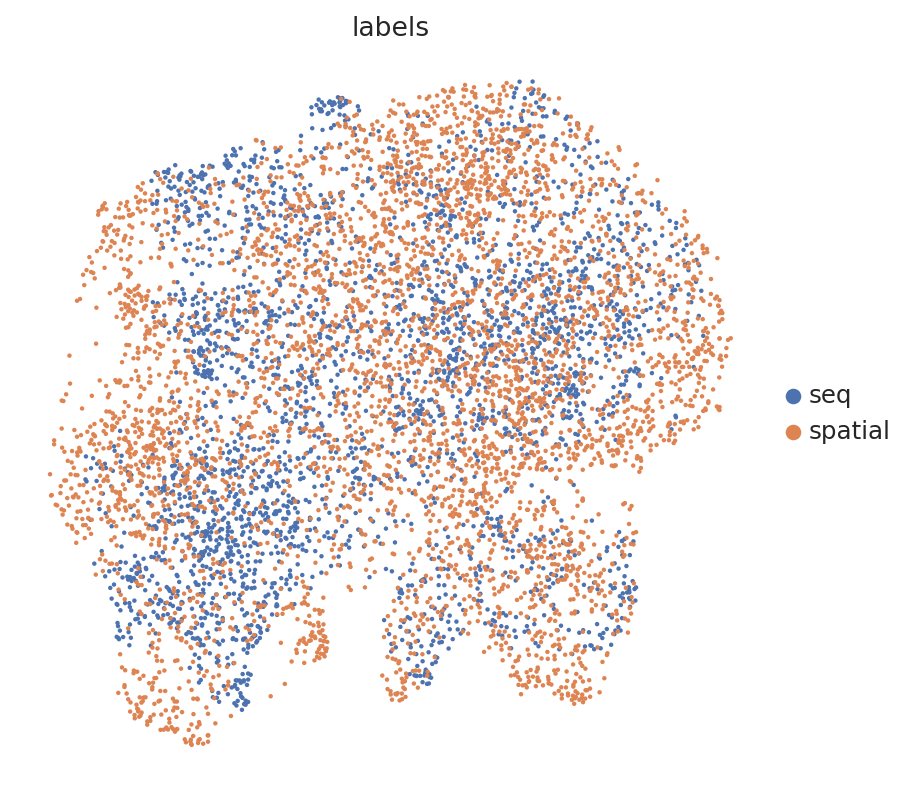

In [9]:
# umap of the combined latent space
sc.pl.umap(latent_adata, color="labels", show=True)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


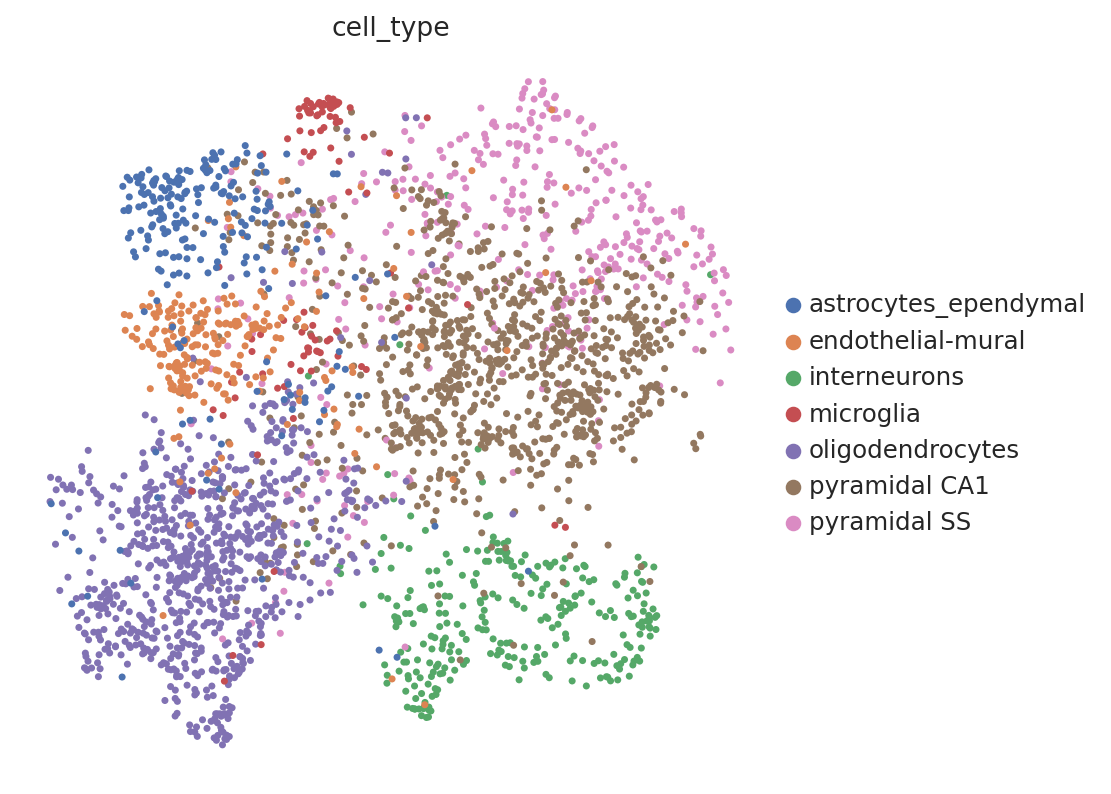

In [10]:
# umap of sequencing dataset
sc.pl.umap(seq_data, color="cell_type")

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


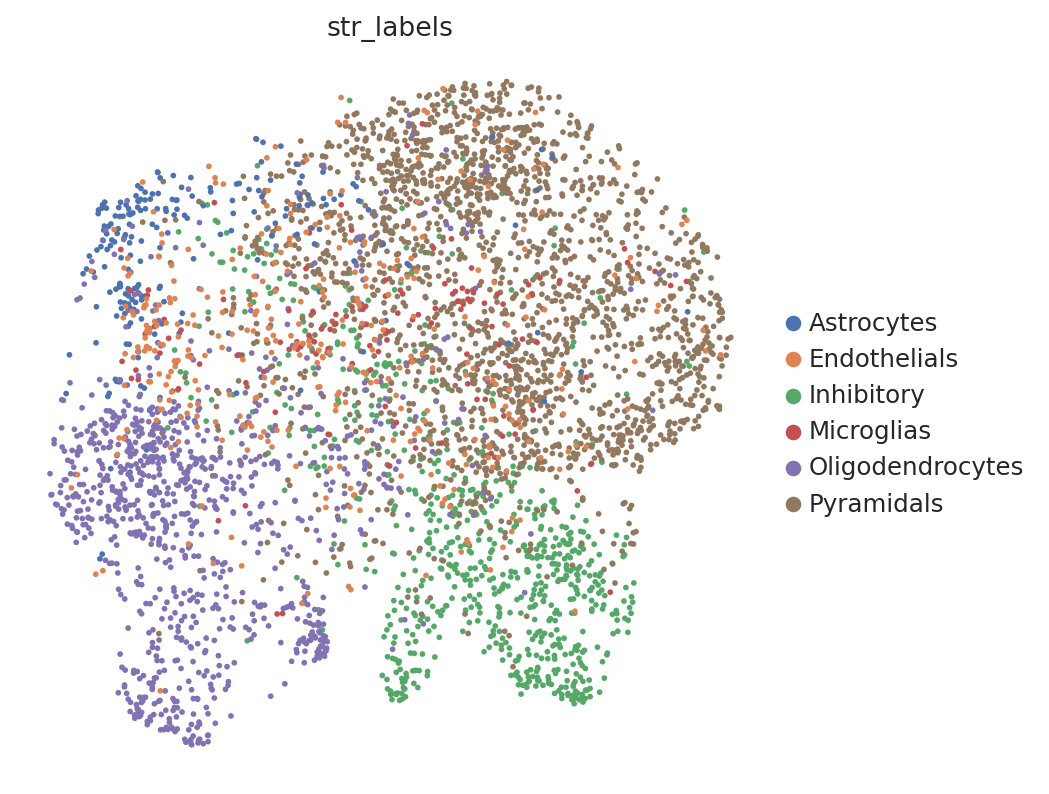

In [11]:
# umap of spatial dataset
sc.pl.umap(spatial_data, color="str_labels")

### Getting Imputation Score

imputation_score() returns the median spearman r correlation over all the cells

In [12]:
# utility function for scoring the imputation


def imputation_score(model, data_spatial, gene_ids_test, normalized=True):
    _, fish_imputation = model.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original = original / data_spatial.X.sum(axis=1).reshape(-1, 1)

    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))


imputation_score(model, spatial_data, rand_test_gene_idx, True)

0.20483781451875224

### Plot imputation for *Lamp5*, which should have been hidden in the training

/tmp/ipykernel_156/3711282922.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[ind], y[ind], z[ind]


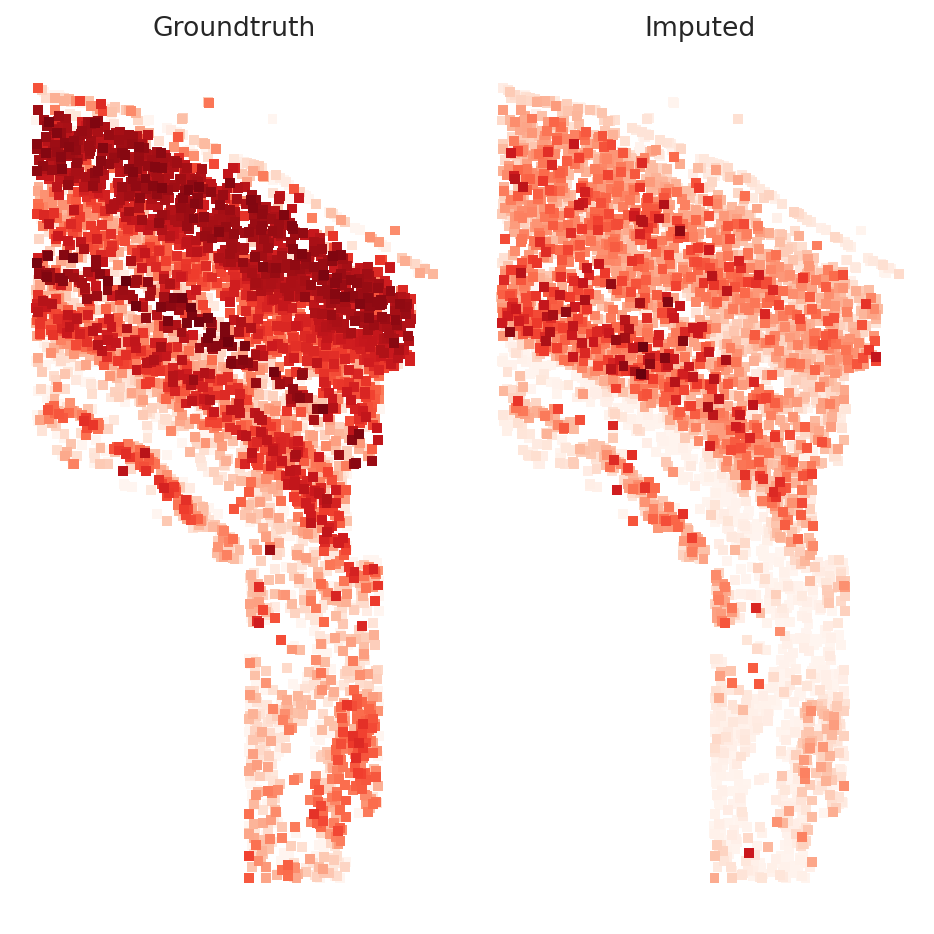

In [13]:
def plot_gene_spatial(model, data_spatial, gene):
    data_seq = model.adatas[0]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if isinstance(gene, str):
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs["x_coord"]
    y_coord = data_fish.obs["y_coord"]

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = model.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


assert "Lamp5" in rand_test_genes
plot_gene_spatial(model, spatial_data, 9)